### Use Find a Car Park Dataset (kaggle)
(https://www.kaggle.com/daggysheep/find-a-car-park)

In [1]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

### Preview Dataset

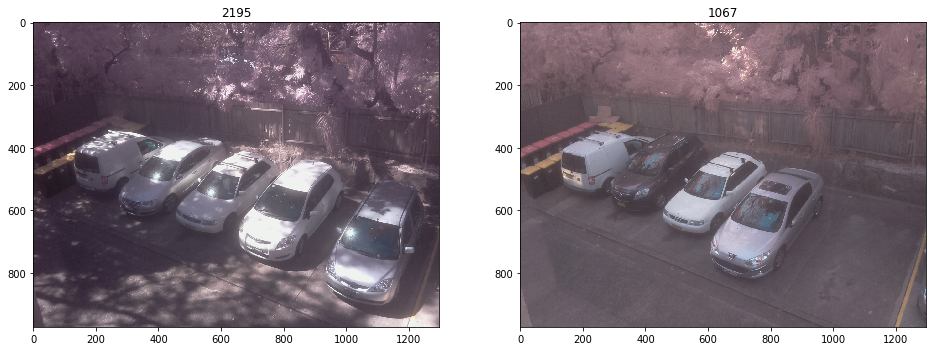

In [2]:
BASE_PATH = 'Data/parking_lot_data'

full_list = glob.glob(os.path.join(BASE_PATH, 'Full/*.jpg'))
free_list = glob.glob(os.path.join(BASE_PATH, 'Free/*.jpg'))

full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.title(len(full_list))
plt.imshow(full_img)
plt.subplot(1, 2, 2)
plt.title(len(free_list))
plt.imshow(free_img)

### Data Generator

In [3]:
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    brightness_range = [0.8, 1.2],
    shear_range = 0.01,
    zoom_range = [0.9, 1.1],
    validation_split = 0.1,
    preprocessing_function = preprocess_input # MobileNetV2를 사용할 예정이기에.
)

val_datagen = ImageDataGenerator(
    validation_split = 0.1,
    preprocessing_function = preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size = (224, 224),
    classes = ['Full', 'Free'],
    class_mode = 'categorical', # Full이면 [1, 0], Free면 [0, 1]로 output.
    batch_size = 32,
    shuffle = True,
    subset = 'training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size = (224, 224),
    classes = ['Full', 'Free'],
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False,
    subset = 'validation'
)

print(val_gen.class_indices)

Found 2937 images belonging to 2 classes.
Found 325 images belonging to 2 classes.
{'Full': 0, 'Free': 1}


### Load Model for Transfer Learning

In [4]:
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x) # Full이면 [1,0]으로 Free면 [0, 1]로 나오게 해야 하기 때문에 output은 2개.

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

9412608/9406464 [==============================] - 198s 21us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________

### Switch Layers to be Trainable

In [5]:
for layer in model.layers:
    layer.trainable = True # 이걸 False로 하면 학습을 해도 layer의 weight가 변하지 않음. 가끔 안되어 있는 모델이 있기에 미리 설정.

### Train

In [7]:
history = model.fit_generator(
    train_gen,
    validation_data = val_gen,
    epochs = 10,
    callbacks = [
        ModelCheckpoint('model.h5', monitor='val_acc', save_best_only=True, verbose=1)
    ]
)


Epoch 1/10
92/92 [==============================] - 593s 6s/step - loss: 0.1348 - acc: 0.9523 - val_loss: 4.2410e-05 - val_acc: 0.9015

Epoch 00001: val_acc improved from -inf to 0.90154, saving model to model.h5
Epoch 2/10
92/92 [==============================] - 666s 7s/step - loss: 0.0508 - acc: 0.9881 - val_loss: 0.0346 - val_acc: 0.8462

Epoch 00002: val_acc did not improve from 0.90154
Epoch 3/10
92/92 [==============================] - 610s 7s/step - loss: 0.0338 - acc: 0.9911 - val_loss: 0.0000e+00 - val_acc: 0.6277

Epoch 00003: val_acc did not improve from 0.90154
Epoch 4/10
92/92 [==============================] - 752s 8s/step - loss: 0.0120 - acc: 0.9969 - val_loss: 1.7032 - val_acc: 0.9600

Epoch 00004: val_acc improved from 0.90154 to 0.96000, saving model to model.h5
Epoch 5/10
92/92 [==============================] - 923s 10s/step - loss: 0.0073 - acc: 0.9986 - val_loss: 4.0724 - val_acc: 0.9662

Epoch 00005: val_acc improved from 0.96000 to 0.96615, saving model to mo

### Create New Model

In [8]:
model = load_model('model.h5')

last_weight = model.layers[-1].get_weights()[0] # 마지막 weight의 dimension은 (1280, 2).

new_model = Model(
    inputs = model.input,
    outputs = (
        model.layers[-3].output,
        model.layers[-1].output
    )
)

new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

### Normal Prediction

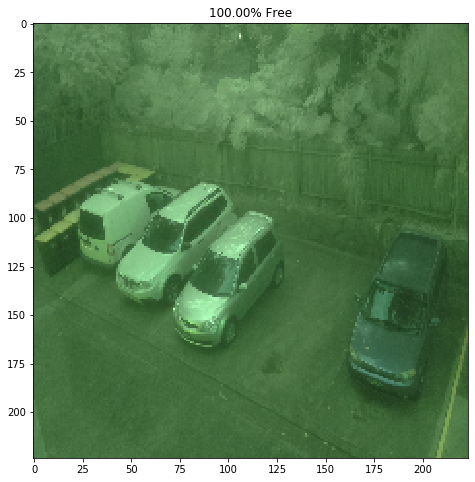

In [9]:
test_img = img_to_array(load_img(os.path.join(BASE_PATH, 'Free/img_815061601.jpg'), target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)

plt.figure(figsize=(8, 8))
plt.title('%.2f%% Free' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

### Draw Activation Map

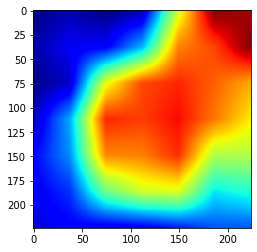

In [10]:
last_conv_output, pred = new_model.predict(test_input)

last_conv_output = np.squeeze(last_conv_output) # 마지막 convolution의 output을 squeeze를 통해 (7, 7, 1280)으로. (global average pooling을 통과하기 전의 size.)
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280)을 scipy.ndimage.zoom을 통해 (224, 224, 1280)으로 확대.

pred_class = np.argmax(pred)
predicted_class_weights = last_weight[:, pred_class]

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224))

plt.imshow(final_output, cmap='jet')

### Result

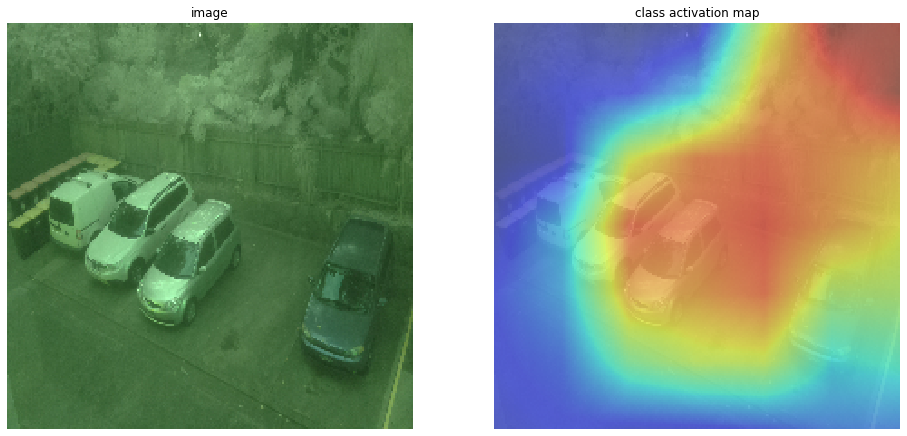

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)

ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()